# How to Access the Hydrology Data Rods Time Series API

### Overview

This notebook describes accessing the [Hydrology Data Rods Time Series API](https://disc.gsfc.nasa.gov/information/tools?title=Hydrology%20Data%20Rods) using Python. It queries a grid over Brisbane, Australia, and queries 10 years of 3-hour GLDASv2.1 total precipitation rate data. Daily sums, means, and z-scores of this data are then calculated and plotted.

### Prerequisites

This notebook was written using Python 3.9, and requires these libraries and files:

- [requests](https://docs.python-requests.org/en/latest/) (version 2.22.0 or later)
- [Pandas](https://pandas.pydata.org/docs/index.html)
- [NumPy](https://numpy.org/doc/stable/index.html)
- [Matplotlib](https://matplotlib.org/)
- [Seaborn](https://seaborn.pydata.org/)


#### Import modules

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import urllib
import urllib.parse as urlp
import io
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#### Define functions that call the data rods services, returns an ASCII, then converts the ASCII to a Pandas dataframe.


In [2]:
def get_time_series(start_date,end_date,latitude,longitude,variable):
    """
    Calls the data rods service to get a time series
    """
    base_url = "https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi"
    query_parameters = {
        "variable": variable,
        "type": "asc2",
        "location": f"GEOM:POINT({longitude}, {latitude})",
        "startDate": start_date,
        "endDate": end_date,
    }
    full_url = base_url+"?"+ \
         "&".join(["{}={}".format(key,urlp.quote(query_parameters[key])) for key in query_parameters])
    print(full_url)
    iteration = 0
    done = False
    while not done and iteration < 5:
        r=requests.get(full_url)
        if r.status_code == 200:
            done = True
        else:
            iteration +=1
    
    if not done:
        raise Exception(f"Error code {r.status_code} from url {full_url} : {r.text}")
    
    return r.text

def parse_time_series(ts_str):
    """
    Parses the response from data rods.
    """
    lines = ts_str.split("\n")
    parameters = {}
    for line in lines[2:11]:
        key,value = line.split("=")
        parameters[key] = value
    
    
    df = pd.read_table(io.StringIO(ts_str),sep="\t",
                       names=["time","data"],
                       header=10,parse_dates=["time"])
    return parameters, df

#### Retrieve our precipitation data at the Brisbane grid

In [11]:

df_ts = parse_time_series(
        get_time_series(
            start_date="2012-06-01T00", 
            end_date="2022-05-31T23",
            latitude=-27.47,
            longitude=153.02,
            variable="GLDAS2:GLDAS_NOAH025_3H_v2.1:Rainf_f_tavg"
        )
    )

df_ts[1]

https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=GLDAS2%3AGLDAS_NOAH025_3H_v2.1%3ARainf_f_tavg&type=asc2&location=GEOM%3APOINT%28153.02%2C%20-27.47%29&startDate=2012-06-01T00&endDate=2022-05-31T23


,time,data
0,2012-06-01 00:00:00,8.445000e-04
1,2012-06-01 03:00:00,9.400000e-05
2,2012-06-01 06:00:00,9.400000e-05
3,2012-06-01 09:00:00,9.400000e-05
4,2012-06-01 12:00:00,9.400000e-05
...,...,...
29211,2022-05-31 09:00:00,6.300000e-06
29212,2022-05-31 12:00:00,1.000000e-07
29213,2022-05-31 15:00:00,0.000000e+00
29214,2022-05-31 18:00:00,4.900000e-06


#### Plot using Matplotlib

''

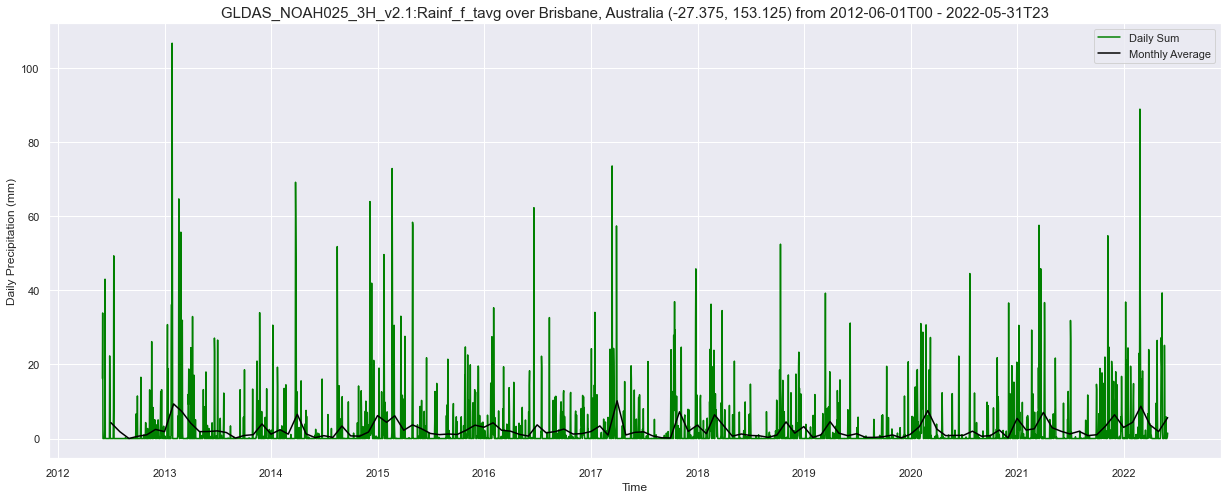

In [4]:
plt.figure(figsize=(21, 8))

# Convert to mm, aggregate over days and months
daily_sum = df_ts[1].groupby(pd.Grouper(key='time', freq='1D')).sum()*3*3600
month_mean = (df_ts[1].groupby(pd.Grouper(key='time', freq='1D')).sum()*3*3600).resample("M").mean()

daily_sum = daily_sum.reset_index()
month_mean = month_mean.reset_index()

plt.plot(daily_sum["time"], daily_sum["data"], color="green")
plt.plot(month_mean["time"], month_mean["data"], color="black")

plt.title("GLDAS_NOAH025_3H_v2.1:Rainf_f_tavg over Brisbane, Australia (-27.375, 153.125) from 2012-06-01T00 - 2022-05-31T23", size=15)
plt.ylabel("Daily Precipitation (mm)")
plt.xlabel("Time")
plt.legend(["Daily Sum", "Monthly Average"])
  
;

#### Add year and month columns to our daily sums dataframe

In [5]:
daily_sum['year'] = ""
daily_sum['month'] = ""
daily_sum['year_ix'] = ""

for i in range(len(daily_sum)):
    daily_sum['year'].iloc[i] = daily_sum['time'].iloc[i].year
    daily_sum['month'].iloc[i] = daily_sum['time'].iloc[i].month

#### Create a Pandas pivot table, aggregate our daily sum values by month

In [6]:
months_pivot = daily_sum.pivot_table(index = "year", values="data", columns="month", aggfunc=np.sum)
months_pivot

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2012,NaN,NaN,NaN,NaN,NaN,128.83860,56.92140,0.24840,18.13320,31.12020,73.80720,57.80916
2013,289.86120,205.18380,128.26080,55.71720,58.89780,62.01360,50.06340,3.93120,24.88860,32.17320,118.00620,36.67140
2014,73.86120,33.38280,202.93740,37.95120,7.73820,23.12820,9.68760,104.59260,21.40020,19.93140,52.55280,191.90520
2015,135.96876,171.79344,69.19884,110.55744,81.79812,41.29920,32.73156,37.83780,32.95080,69.71940,108.46224,94.68144
2016,131.66712,65.22768,61.44876,34.04268,20.38824,110.66652,47.59884,58.43880,76.63356,37.54080,39.82392,58.11264
2017,105.53436,25.99128,315.64836,28.92024,51.87672,54.18144,22.21776,6.18300,4.21200,223.82028,57.64392,112.13748
2018,40.52700,179.59860,107.89200,19.61712,38.07000,24.84216,23.16600,9.96192,28.29924,139.32000,43.75944,100.08900
2019,9.50724,28.18908,141.17436,43.48080,23.66388,39.09708,9.46188,9.69300,14.49900,30.15684,5.92812,35.38296
2020,99.39780,218.58984,78.35508,23.64552,26.43516,25.58196,61.48980,19.37844,22.81068,71.27136,5.21424,168.79968


#### Calculate 10-year z-scores of total monthly precipitation for our Brisbane grid

In [7]:
# Copy pivot table that will serve as our z-scores table
months_zscore = months_pivot.astype('float64')

for yr_ix in range(2012, 2023):
    for mo in range(1, 13):
        months_zscore[mo][yr_ix] = (months_pivot[mo][yr_ix] - months_pivot[mo].mean()) / months_pivot[mo].std()

#### Plot these results using a Seaborn "heatmap"

Text(0.5, 0.98, 'GLDAS Monthly Z-Scores of Total Precipitation in Brisbane, June-May 2012-2022')

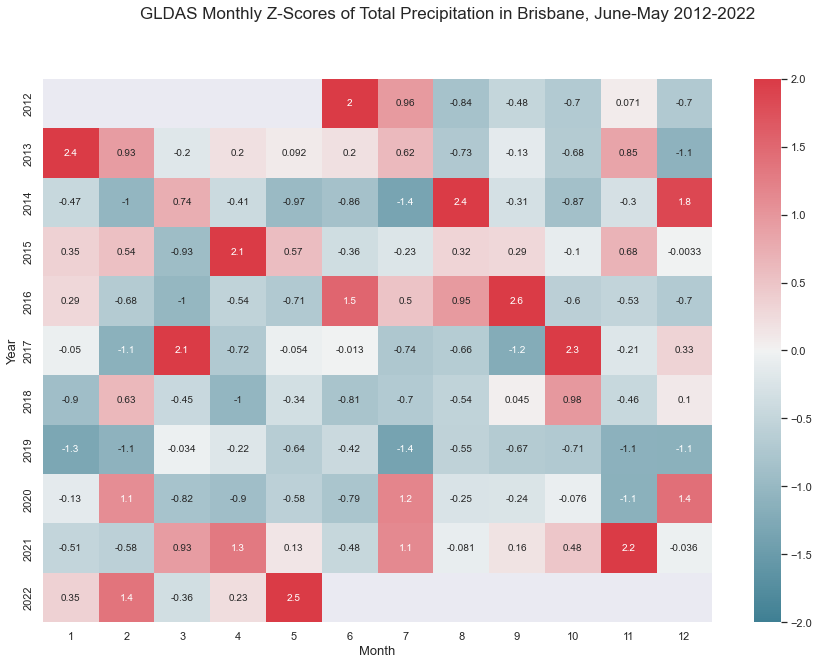

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))
diverge = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(months_zscore, cmap=diverge, center=0, vmin=-2, vmax=2, annot=True)
ax.set_xlabel("Month", fontsize=13)
ax.set_ylabel("Year", fontsize=13)

fig.suptitle("GLDAS Monthly Z-Scores of Total Precipitation in Brisbane, June-May 2012-2022", fontsize=17)